# Machine Learning Approaches to Better Utilize HM450K Data in Cancer Analysis
## Aim 1: Utilize Machine Learning to Determine Tumor State
### Approach 1: Can LLE dimensionality reduction aid in machine learning identification of tumor state? 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import multiprocessing
import os
import pprint

import numpy as np
import pandas as pd
import shap
from IPython import get_ipython
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, classification_report)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils import (RANDOM_STATE, get_tumor_normal_ml_data,
                   stratified_train_test_split)

In [4]:
ip = get_ipython()
path = None
if "__vsc_ipynb_file__" in ip.user_ns:
    path = ip.user_ns["__vsc_ipynb_file__"]

currfile = os.path.splitext(os.path.basename(path))[0]
currfile

'02_dim_red_prediction'

#### Load and prep the data

The first step in this analysis is to load the data in and prep it. To do this we remove all features with less than 80% of the samples having data. This ensures that after our train-test split, there will be some data for all used features prior to imputing.

In [5]:
X, y = get_tumor_normal_ml_data()

In [6]:
def prep_data(X, y):
    """
    Prepares the data for machine learning by performing the following steps:
    1. Filters out columns in X that have more than 80% missing values.
    2. Splits the filtered data into training and testing sets using stratified sampling.
    3. Converts the training and testing sets to numpy arrays.
    4. Imputes missing values in the training and testing sets using the mean strategy.
    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target vector.
    Returns:
    tuple: A tuple containing:
        - X_filtered (pd.DataFrame): The filtered feature matrix.
        - X_train (np.ndarray): The training feature matrix.
        - X_test (np.ndarray): The testing feature matrix.
        - y_train (np.ndarray): The training target vector.
        - y_test (np.ndarray): The testing target vector.
    """
    X_filtered = X.loc[:, X.isna().mean() < 0.8]
    print(
        "Dropped {N} columns with all NaN values".format(
            N=X.shape[1] - X_filtered.shape[1]
        )
    )
    X_train, X_test, y_train, y_test = stratified_train_test_split(X_filtered, y)
    X_train, X_test, y_train, y_test = (
        X_train.to_numpy(),
        X_test.to_numpy(),
        y_train.to_numpy(),
        y_test.to_numpy(),
    )
    imp = SimpleImputer(strategy="mean")
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    return X_filtered, X_train, X_test, y_train, y_test

In [7]:
X_filtered, X_train, X_test, y_train, y_test = prep_data(X, y)

Dropped 36814 columns with all NaN values


In [8]:
X_filtered

id,cg21870274,cg08258224,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,cg04195702,...,cg26348521,cg03370490,cg16974513,cg23628760,cg04920704,cg07236001,cg27267896,cg23079702,cg21073216,cg22820726
TCGA-CH-5748-01A,0.645758,0.656690,0.987074,0.829817,0.765562,0.563975,0.923610,0.902567,0.961790,0.888071,...,0.910931,0.973111,0.980881,0.939469,0.867463,0.853483,0.909006,0.832059,0.865772,0.926564
TCGA-EJ-5505-01A,0.870373,0.627945,0.434555,0.741031,0.857144,0.682411,0.920843,0.908726,0.963588,0.938181,...,0.910432,0.974415,0.976944,0.924600,0.861252,0.920901,0.913034,0.870088,0.836950,0.953433
TCGA-CH-5771-01A,0.654246,0.620589,0.553659,0.672388,0.780095,0.583021,0.907692,0.898535,0.961951,0.917109,...,0.892197,0.966635,0.978560,0.915386,0.870033,0.837269,0.910727,0.823006,0.812190,0.931413
TCGA-EJ-5502-01A,0.689684,0.718724,0.561286,0.727417,0.792205,0.601268,0.942951,0.911031,0.967079,0.915990,...,0.924589,0.978463,0.977904,0.934070,0.913384,0.859400,0.929054,0.842740,0.867377,0.942014
TCGA-CH-5738-01A,0.725973,0.750501,0.490818,0.774847,0.705349,0.395335,0.777662,0.911745,0.967098,0.922760,...,0.915244,0.966887,0.981029,0.925079,0.872097,0.880066,0.907857,0.855435,0.850567,0.952393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E9-A1RD-11A_y,0.000069,0.000079,0.000042,0.000056,0.000069,0.000042,0.000080,0.000082,0.000095,0.000083,...,0.000090,0.000097,0.000097,0.000094,0.000081,0.000072,0.000083,0.000091,0.000075,0.000088
TCGA-BH-A1FR-11B_y,0.000073,0.000087,0.000037,0.000055,0.000070,0.000036,0.000083,0.000088,0.000097,0.000092,...,0.000090,0.000097,0.000097,0.000089,0.000081,0.000072,0.000085,0.000091,0.000086,0.000092
TCGA-E9-A1RC-11A_y,0.000080,0.000083,0.000030,0.000049,0.000084,0.000075,0.000089,0.000090,0.000095,0.000074,...,0.000094,0.000096,0.000093,0.000092,0.000079,0.000074,0.000089,0.000086,0.000073,0.000087
TCGA-BH-A1F8-11B_y,0.000076,0.000082,0.000038,0.000056,0.000079,0.000041,0.000083,0.000087,0.000096,0.000090,...,0.000089,0.000097,0.000097,0.000095,0.000084,0.000077,0.000090,0.000088,0.000085,0.000093


In [9]:
X_filtered.shape, y.shape

((2733, 238284), (2733,))

In [10]:
# num_cpus = multiprocessing.cpu_count() // 2
num_cpus = 10

#### Hyperparameter tuning

To find the best hyperparameters for our pipeline, we will use RandomizedSearchCV. The parameters we are tuning are:

For the LocallyLinearEmbedding model:
- n_components
- n_neighbors
- tol
- max_iter
- hessian_tol

For the LogisticRegression model:
- tol
- l1_ratio
- max_iter


In [11]:
# If file best_params.json exists, load it
try:
    with open(f"{currfile}.best_params.json", "r") as file:
        best_params = json.load(file)
    results = pd.read_csv(f"{currfile}.hyperparmeter_tuning_results.csv")

except FileNotFoundError:
    best_params = None
    param_grid = {
        "classifier__tol": np.logspace(-6, -3, 10),
        "classifier__l1_ratio": np.linspace(0, 1, 20),
        "classifier__C": np.arange(2, 26, 5),
        "classifier__max_iter": np.arange(75, 151, 5),
        "embedder__n_components": np.arange(500, 2000, 250),
        "embedder__n_neighbors": np.arange(2, 100, 5),
        "embedder__tol": np.logspace(-6, -3, 10),
        "embedder__max_iter": np.arange(75, 151, 5),
        "embedder__hessian_tol": np.logspace(-6, -3, 10),
    }

    pipeline = Pipeline(
        [
            # ("imputer", SimpleImputer(strategy="mean")),
            ("embedder", LocallyLinearEmbedding(random_state=RANDOM_STATE, n_jobs=num_cpus, neighbors_algorithm="kd_tree")),
            (
                "classifier",
                LogisticRegression(
                    random_state=RANDOM_STATE,
                    n_jobs=num_cpus,
                    penalty="elasticnet",
                    solver="saga",
                    class_weight="balanced",
                ),
            ),
        ]
    )

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=5,
        n_jobs=num_cpus,
        n_iter=20,
        random_state=RANDOM_STATE,
        scoring="precision",
    )

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_

    results = pd.DataFrame(random_search.cv_results_)

    param_details = pd.json_normalize(results["params"])
    results = pd.concat([results, param_details], axis=1)

    results.to_csv(f"{currfile}.hyperparmeter_tuning_results.csv")
    best_params_serializable = {
        k: int(v) if isinstance(v, np.integer) else v for k, v in best_params.items()
    }

    with open(f"{currfile}.best_params.json", "w") as file:
        json.dump(best_params_serializable, file)

In [12]:
results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_embedder__tol,param_embedder__n_neighbors,param_embedder__n_components,param_embedder__max_iter,param_embedder__hessian_tol,...,rank_test_score,embedder__tol,embedder__n_neighbors,embedder__n_components,embedder__max_iter,embedder__hessian_tol,classifier__tol,classifier__max_iter,classifier__l1_ratio,classifier__C
0,0,395.022680,3.970357,97.339429,2.771022,0.000005,72,750,90,0.000010,...,2,0.000005,72,750,90,0.000010,0.000464,100,0.631579,12
1,1,52.481340,0.912714,10.432004,0.595324,0.000022,7,1500,125,0.000010,...,14,0.000022,7,1500,125,0.000010,0.000010,125,0.263158,7
2,2,56.991632,1.662361,10.116425,0.354069,0.000001,12,750,125,0.000215,...,13,0.000001,12,750,125,0.000215,0.000002,130,0.157895,22
3,3,349.182125,4.813307,0.000000,0.000000,0.000022,62,1750,80,0.000010,...,18,0.000022,62,1750,80,0.000010,0.000002,110,0.157895,22
4,4,402.507469,9.834318,106.129931,3.916180,0.000001,77,1000,135,0.000001,...,1,0.000001,77,1000,135,0.000001,0.000001,140,0.052632,7
5,5,316.448217,1.966369,74.181949,1.842637,0.000010,57,1250,80,0.000002,...,10,0.000010,57,1250,80,0.000002,0.000010,100,0.105263,17
6,6,487.249012,12.783804,122.648787,7.729633,0.000464,87,500,105,0.000046,...,6,0.000464,87,500,105,0.000046,0.001000,135,0.052632,7
7,7,41.761325,0.884643,8.154885,0.300699,0.000022,7,750,75,0.000022,...,17,0.000022,7,750,75,0.000022,0.000100,150,0.684211,2
8,8,42.605473,0.743765,8.093013,0.252497,0.000001,7,1000,80,0.000010,...,16,0.000001,7,1000,80,0.000010,0.001000,80,0.421053,2
9,9,457.565158,14.091931,111.068794,2.108608,0.000022,77,1500,90,0.000005,...,8,0.000022,77,1500,90,0.000005,0.000010,90,0.210526,17


In [13]:
print("Best parameters:")
pprint.pprint(best_params)

Best parameters:
{'classifier__C': 7,
 'classifier__l1_ratio': 0.05263157894736842,
 'classifier__max_iter': 140,
 'classifier__tol': 1e-06,
 'embedder__hessian_tol': 1e-06,
 'embedder__max_iter': 135,
 'embedder__n_components': 1000,
 'embedder__n_neighbors': 77,
 'embedder__tol': 1e-06}


#### Train classification pipeline with best parameters

After finding the best hyperparameters using RandomSearchCV, the next step is to train the final pipeline with those parameters

In [14]:
embedder_args = {k.split("__")[1]: v for k, v in best_params.items() if "embedder" in k}
classifier_args = {k.split("__")[1]: v for k, v in best_params.items() if "classifier" in k}

classification_pipeline = Pipeline(
    [
        # ("imputer", SimpleImputer(strategy="mean")),
        (
            "embedder",
            LocallyLinearEmbedding(random_state=RANDOM_STATE, n_jobs=num_cpus, neighbors_algorithm="kd_tree", **embedder_args),
        ),
        (
            "classifier",
            LogisticRegression(
                random_state=RANDOM_STATE,
                n_jobs=num_cpus,
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                **classifier_args,
            ),
        ),
    ]
)

classification_pipeline.fit(X_train, y_train)

Pipeline(steps=[('embedder',
                 LocallyLinearEmbedding(hessian_tol=1e-06, max_iter=135,
                                        n_components=1000, n_jobs=10,
                                        n_neighbors=77,
                                        neighbors_algorithm='kd_tree',
                                        random_state=42)),
                ('classifier',
                 LogisticRegression(C=7, class_weight='balanced',
                                    l1_ratio=0.05263157894736842, max_iter=140,
                                    n_jobs=10, penalty='elasticnet',
                                    random_state=42, solver='saga',
                                    tol=1e-06))])

#### Results

To see the performance of the pipeline we will plot the confusion matrix, ROC curve, and the Precision-Recall Curve

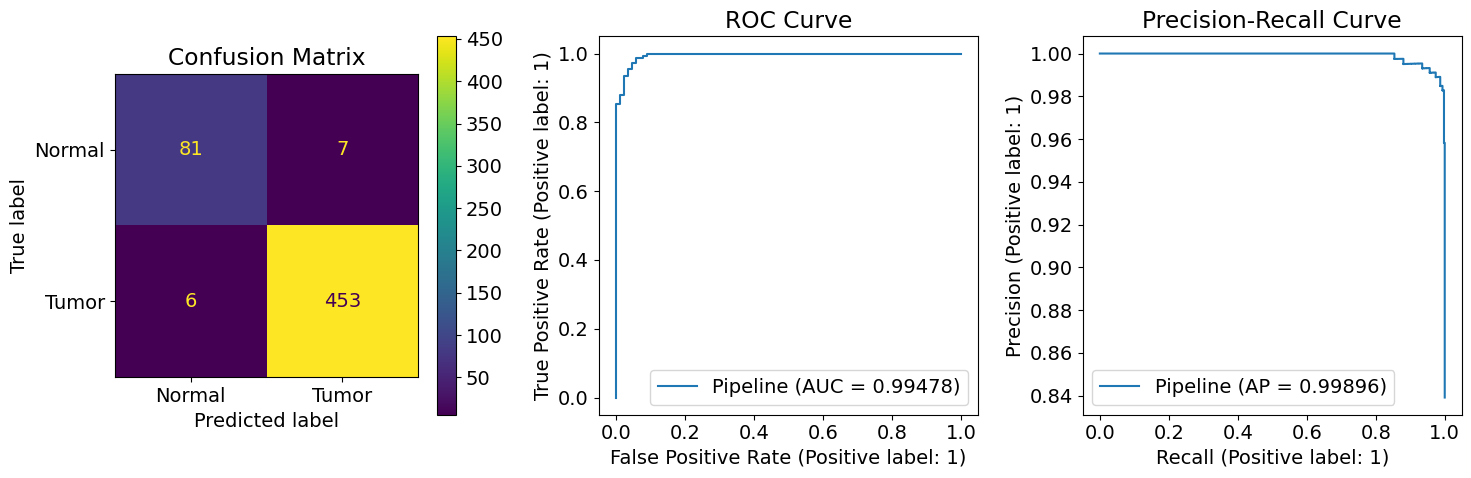

In [17]:
plt.rcParams.update({"font.size": 14})

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(
    classification_pipeline,
    X_test,
    y_test,
    ax=ax[0],
    display_labels=["Normal", "Tumor"],
)
ax[0].set_title("Confusion Matrix")

roc_display = RocCurveDisplay.from_estimator(
    classification_pipeline,
    X_test,
    y_test,
    ax=ax[1],
)
ax[1].set_title("ROC Curve")
roc_display.line_.set_label(f"Pipeline (AUC = {roc_display.roc_auc:.5f})")
ax[1].legend()

pr_display = PrecisionRecallDisplay.from_estimator(
    classification_pipeline,
    X_test,
    y_test,
    ax=ax[2],
)
ax[2].set_title("Precision-Recall Curve")
pr_display.line_.set_label(f"Pipeline (AP = {pr_display.average_precision:.5f})")
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_test, classification_pipeline.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        88
           1       0.99      0.97      0.98       459

    accuracy                           0.97       547
   macro avg       0.93      0.97      0.95       547
weighted avg       0.97      0.97      0.97       547



#### Explainable AI analysis

To interpret our model, we will implement SHAP to determine the features of most importance. We will attempt to implement it in 3 ways

1. Explain the Classifier alone with the reduced feature set from LLE
   - This will allow us to test SHAP on out model, for LLE embeddings, this is not going to add much explainability as there is not at way to reverse the embeddings
2. Explain the whole pipeline
   - This is the ideal solution to determine what features are the most important, but due to the high dimensionality of our data, may not be possible   
3. Utilize SKLearn permutation_importance
   - This implementation would use less memory and therefore be a possible way to add explainability, but also may take too much time 

In [ ]:
shap.initjs()

In [ ]:
feature_names = X_filtered.columns
len(feature_names)

238284

In [ ]:
transformed_feature_names = classification_pipeline[:-1].get_feature_names_out(
    feature_names
)
transformed_feature_names

array(['locallylinearembedding0', 'locallylinearembedding1',
       'locallylinearembedding2', 'locallylinearembedding3',
       'locallylinearembedding4', 'locallylinearembedding5',
       'locallylinearembedding6', 'locallylinearembedding7',
       'locallylinearembedding8', 'locallylinearembedding9',
       'locallylinearembedding10', 'locallylinearembedding11',
       'locallylinearembedding12', 'locallylinearembedding13',
       'locallylinearembedding14', 'locallylinearembedding15',
       'locallylinearembedding16', 'locallylinearembedding17',
       'locallylinearembedding18', 'locallylinearembedding19',
       'locallylinearembedding20', 'locallylinearembedding21',
       'locallylinearembedding22', 'locallylinearembedding23',
       'locallylinearembedding24', 'locallylinearembedding25',
       'locallylinearembedding26', 'locallylinearembedding27',
       'locallylinearembedding28', 'locallylinearembedding29',
       'locallylinearembedding30', 'locallylinearembedding31',
  

In [ ]:
explainer = shap.LinearExplainer(
    classification_pipeline.named_steps["classifier"],
    classification_pipeline[:-1].transform(X_train),
    feature_names=transformed_feature_names,
)

In [ ]:
explanations = explainer(classification_pipeline[:-1].transform(X_test))

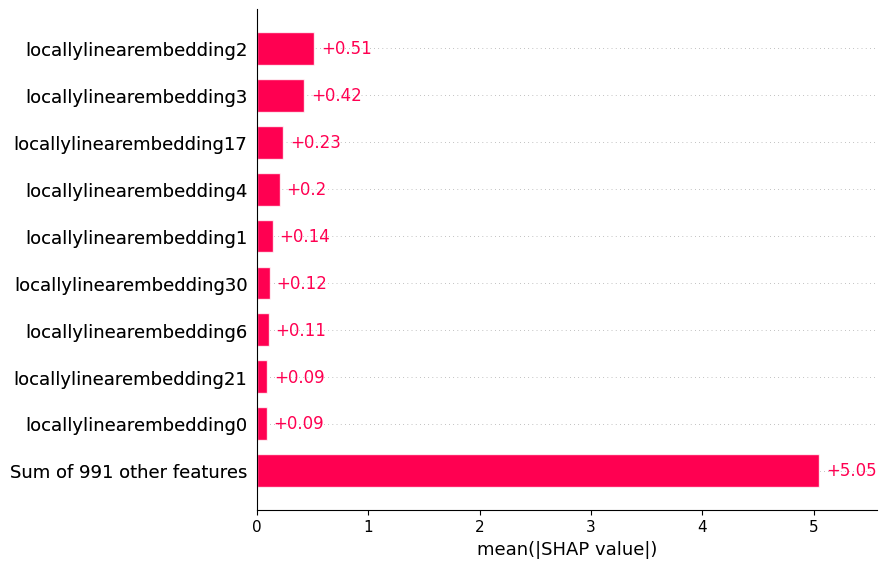

In [ ]:
shap.plots.bar(explanations)

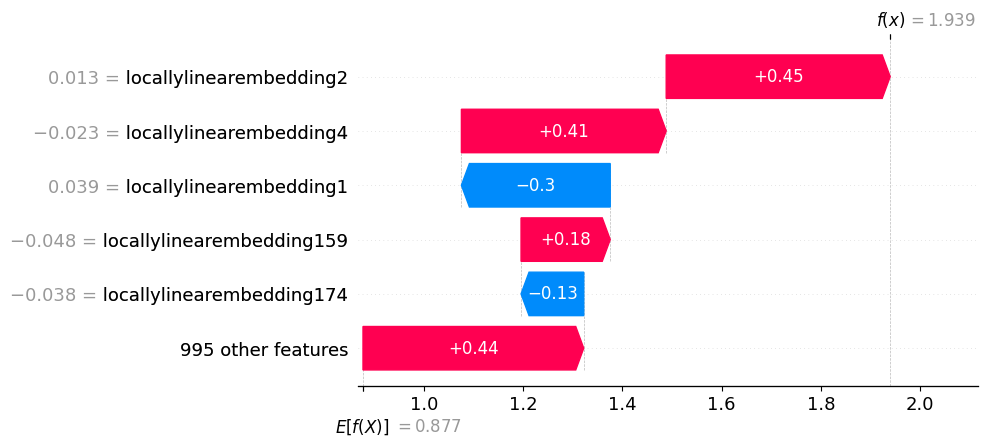

In [ ]:
shap.plots.waterfall(explanations[0], max_display=6)

In [ ]:
X_test[0].shape

(238284,)

In [ ]:
shap.sample(X_test, 100).shape

(100, 238284)

In [ ]:
explainer = shap.KernelExplainer(
    classification_pipeline.predict,
    shap.sample(X_test, 100),
    feature_names=feature_names,
)

In [ ]:
explanations = explainer(X_test.iloc[0])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    classification_pipeline, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=20
)

# Map importance scores to original feature names
feature_importances = dict(zip(feature_names, result.importances_mean))